In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import wandb

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

Device Used: cuda


In [5]:
# Hyperparameters
IMG_SIZE = 64
BATCH_SIZE = 64
LATENT_DIM = 128
LEARNING_RATE = 0.0001

In [6]:
# Custom Dataset for AFHQ
class AFHQDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.class_mapping = {}
        
        extensions = (".jpg", ".jpeg", ".png")
        # Walk through all subdirectories
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            full_path = os.path.join(root_dir, category)
            if os.path.exists(full_path):
                self.class_mapping[label] = category
                for img_name in os.listdir(full_path):
                    if img_name.endswith(extensions):
                        self.image_paths.append(os.path.join(full_path, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [7]:
transform = transforms.Compose([
        # transforms.GaussianBlur(3, sigma=(0.1, 2.0))
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [8]:
# Paths and hyperparameters
train_dir = '/home/user/javeda1/stargan-v2/data/afhq/train'
val_dir = '/home/user/javeda1/stargan-v2/data/afhq/val'

batch_size = 64
# train_ratio = 0.8  # 80% for train 20% for val

In [9]:
train_dataset = AFHQDataset(root_dir=train_dir, transform=transform)
val_dataset = AFHQDataset(root_dir=val_dir, transform=transform)

# DataLoaders for train and val sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [10]:
def visualize_images(dataset, category_label, num_images=15, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """
    Visualizes the first `num_images` images for a given category label.
    
    Args:
        dataset (AFHQDataset): The dataset to visualize.
        category_label (str): The category to filter for visualization.
        num_images (int): Number of images to display.
        mean (tuple): Mean used for normalization (if applied).
        std (tuple): Std deviation used for normalization (if applied).
    """
    def denormalize(tensor, mean, std):
        """Denormalizes a tensor image."""
        mean = torch.tensor(mean).view(3, 1, 1)
        std = torch.tensor(std).view(3, 1, 1)
        return tensor * std + mean

    images_shown = 0
    plt.figure(figsize=(num_images * 2, 2))

    for i in range(len(dataset)):
        img = dataset[i]
        img_path = dataset.image_paths[i]
        # Check if the image belongs to the specified category
        if category_label in img_path:
            img = denormalize(img, mean, std)  # Denormalize the image
            img = img.clamp(0, 1)  # Ensure values are in [0, 1]

            plt.subplot(1, num_images, images_shown + 1)
            plt.imshow(img.permute(1, 2, 0).numpy())
            plt.axis("off")
            plt.title(category_label, fontsize=8)
            
            images_shown += 1
            if images_shown >= num_images:
                break

    plt.suptitle(f"Images for category: {category_label}", fontsize=16)
    plt.show()

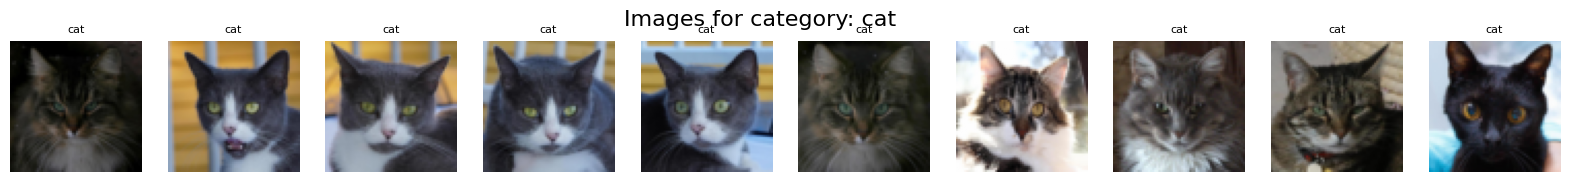

In [11]:
# Visualize images from a specific category
visualize_images(train_dataset, category_label="cat", num_images=10)


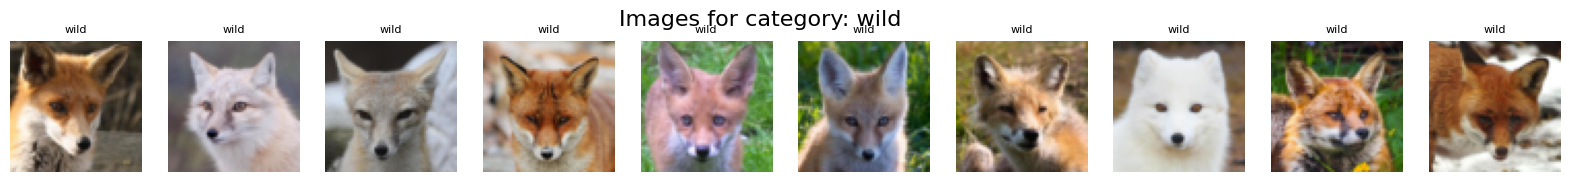

In [10]:
visualize_images(train_dataset, category_label="wild", num_images=10)


In [25]:
def vae_loss_function(recon_x, x, mu, log_var):
    """
    VAE loss: Reconstruction loss + KL divergence
    """
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')  # Reconstruction loss
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  # KL divergence
    return recon_loss + kl_divergence


def train_vae(model, train_loader, optimizer, device):
    """
    Train the VAE for one epoch.
    """
    model.train()
    running_loss = 0.0

    for inputs in train_loader:  # Labels are not needed for VAE
        inputs = inputs.to(device)
        optimizer.zero_grad()

        recon_x, mu, log_var = model(inputs)
        loss = vae_loss_function(recon_x, inputs, mu, log_var)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader.dataset)
    return avg_loss


def evaluate_vae(model, eval_loader, device):
    """
    Evaluate the VAE after each epoch.
    """
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for inputs in eval_loader:
            inputs = inputs.to(device)
            recon_x, mu, log_var = model(inputs)
            loss = vae_loss_function(recon_x, inputs, mu, log_var)
            running_loss += loss.item()

    avg_loss = running_loss / len(eval_loader.dataset)
    return avg_loss


def run_vae_training(
    model, train_loader, eval_loader, device, num_epochs, learning_rate=0.001, project="vae_training", name="vae_run"
):
    """
    Train and evaluate the VAE with W&B logging.
    """
    wandb.init(project=project, name=name, config={"learning_rate": learning_rate, "num_epochs": num_epochs})
    config = wandb.config

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    eval_losses = []

    for epoch in tqdm(range(num_epochs)):
        train_loss = train_vae(model, train_loader, optimizer, device)
        eval_loss = evaluate_vae(model, eval_loader, device)

        train_losses.append(train_loss)
        eval_losses.append(eval_loss)

        # Log metrics to W&B
        wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "eval_loss": eval_loss})

        # Print stats
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Eval Loss: {eval_loss:.4f}")

    wandb.finish()
    return model, train_losses, eval_losses

In [17]:
# Encoder Network
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)  # 64x64 -> 32x32
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)  # 32x32 -> 16x16
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)  # 16x16 -> 8x8
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)  # 8x8 -> 4x4
        
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(256 * 4 * 4, latent_dim)
        
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.batch_norm1(self.conv2(x)))
        x = self.leaky_relu(self.batch_norm2(self.conv3(x)))
        x = self.leaky_relu(self.batch_norm3(self.conv4(x)))
        
        x = x.view(x.size(0), -1)
        
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        
        return mu, log_var

# Decoder Network
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)
        
        self.conv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)  # 4x4 -> 8x8
        self.conv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)   # 8x8 -> 16x16
        self.conv3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)    # 16x16 -> 32x32
        self.conv4 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)     # 32x32 -> 64x64
        
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(128)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = self.relu(self.fc(x))
        x = x.view(x.size(0), 256, 4, 4)
        
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.relu(self.batch_norm3(self.conv3(x)))
        x = torch.tanh(self.conv4(x))
        
        return x

# VAE class combining Encoder and Decoder
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

In [26]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)
        
    def forward(self, x):
        residual = x
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.leaky_relu(x, 0.2)
        return x

class EnhancedEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(EnhancedEncoder, self).__init__()
        
        # Initial convolution
        self.conv_initial = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        
        # Downsampling blocks
        self.conv1 = nn.Conv2d(64, 128, 4, stride=2, padding=1)    # 64x64 -> 32x32
        self.conv2 = nn.Conv2d(128, 256, 4, stride=2, padding=1)   # 32x32 -> 16x16
        self.conv3 = nn.Conv2d(256, 512, 4, stride=2, padding=1)   # 16x16 -> 8x8
        self.conv4 = nn.Conv2d(512, 1024, 4, stride=2, padding=1)  # 8x8 -> 4x4
        
        # Residual blocks
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(256)
        self.res3 = ResidualBlock(512)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)
        self.bn4 = nn.BatchNorm2d(1024)
        
        # Bottleneck
        self.fc_mu = nn.Linear(1024 * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(1024 * 4 * 4, latent_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Initial convolution
        x = F.leaky_relu(self.conv_initial(x), 0.2)
        
        # Downsampling path with residual connections
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = self.res1(x)
        
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = self.res2(x)
        
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = self.res3(x)
        
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        
        # Flatten and apply dropout
        x = self.dropout(x.view(x.size(0), -1))
        
        # Generate latent parameters
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        
        return mu, log_var

class ResidualBlockTranspose(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlockTranspose, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, in_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.ConvTranspose2d(in_channels, in_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

class EnhancedDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(EnhancedDecoder, self).__init__()
        
        # Initial fully connected layer
        self.fc = nn.Linear(latent_dim, 1024 * 4 * 4)
        
        # Upsampling blocks
        self.conv1 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1)  # 4x4 -> 8x8
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)   # 8x8 -> 16x16
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)   # 16x16 -> 32x32
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)    # 32x32 -> 64x64
        
        # Residual blocks
        self.res1 = ResidualBlockTranspose(512)
        self.res2 = ResidualBlockTranspose(256)
        self.res3 = ResidualBlockTranspose(128)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)
        
        # Final convolution for output
        self.conv_final = nn.Conv2d(64, 3, 3, stride=1, padding=1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Reshape from latent space
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), 1024, 4, 4)
        
        # Upsampling path with residual connections
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.res2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.res3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        
        # Final convolution with tanh activation
        x = torch.tanh(self.conv_final(x))
        
        return x

class EnhancedConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(EnhancedConvVAE, self).__init__()
        self.encoder = EnhancedEncoder(latent_dim)
        self.decoder = EnhancedDecoder(latent_dim)
        
    def reparameterize(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu
        
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

latent_dim=512
model = EnhancedConvVAE(latent_dim=latent_dim).to(device)

In [18]:
latent_dim = 512
model = ConvVAE(latent_dim=latent_dim).to(device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [27]:
model

EnhancedConvVAE(
  (encoder): EnhancedEncoder(
    (conv_initial): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (res1): ResidualBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (res2): ResidualBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, moment

In [28]:
model, train_losses, eval_losses = run_vae_training(
    model, train_loader, val_loader, device, num_epochs=30, learning_rate=0.001
)

  3%|█▊                                                      | 1/30 [00:16<07:44, 16.01s/it]

Epoch 1/30
Train Loss: 158949.8815
Eval Loss: 4042774529468127232.0000


  7%|███▋                                                    | 2/30 [00:32<07:29, 16.06s/it]

Epoch 2/30
Train Loss: 42012.2517
Eval Loss: 3716.1961


 10%|█████▌                                                  | 3/30 [00:48<07:15, 16.14s/it]

Epoch 3/30
Train Loss: 4051.9169
Eval Loss: 4394.3131


 13%|███████▍                                                | 4/30 [01:04<07:02, 16.24s/it]

Epoch 4/30
Train Loss: 44167059758.6669
Eval Loss: 5660.2198


 17%|█████████▎                                              | 5/30 [01:21<06:48, 16.32s/it]

Epoch 5/30
Train Loss: 137642057.1031
Eval Loss: 4892.0842


 20%|███████████▏                                            | 6/30 [01:37<06:34, 16.44s/it]

Epoch 6/30
Train Loss: 118493.8637
Eval Loss: 5644.3476


 23%|█████████████                                           | 7/30 [01:54<06:20, 16.53s/it]

Epoch 7/30
Train Loss: 8512.9059
Eval Loss: 3616.7819


 27%|██████████████▉                                         | 8/30 [02:11<06:04, 16.55s/it]

Epoch 8/30
Train Loss: 3583.7675
Eval Loss: 3433.3485


 30%|████████████████▊                                       | 9/30 [02:27<05:48, 16.59s/it]

Epoch 9/30
Train Loss: 3791.1121
Eval Loss: 3598.7296


 33%|██████████████████▎                                    | 10/30 [02:44<05:31, 16.60s/it]

Epoch 10/30
Train Loss: 4090.0685
Eval Loss: 3756.5737


 37%|████████████████████▏                                  | 11/30 [03:01<05:15, 16.61s/it]

Epoch 11/30
Train Loss: 1688802.5964
Eval Loss: 5174.5848


 40%|██████████████████████                                 | 12/30 [03:17<04:59, 16.62s/it]

Epoch 12/30
Train Loss: 632739.6636
Eval Loss: 578397586.7139


 43%|███████████████████████▊                               | 13/30 [03:34<04:42, 16.62s/it]

Epoch 13/30
Train Loss: 1859034.8772
Eval Loss: 4444.1536


 47%|█████████████████████████▋                             | 14/30 [03:51<04:26, 16.63s/it]

Epoch 14/30
Train Loss: 193838488437731.0625
Eval Loss: 11974.3896


 50%|███████████████████████████▌                           | 15/30 [04:07<04:09, 16.60s/it]

Epoch 15/30
Train Loss: 1749257.7162
Eval Loss: 325042457.9789


 53%|█████████████████████████████▎                         | 16/30 [04:24<03:52, 16.62s/it]

Epoch 16/30
Train Loss: 21886.5820
Eval Loss: 14503.5448


 57%|███████████████████████████████▏                       | 17/30 [04:40<03:35, 16.61s/it]

Epoch 17/30
Train Loss: 777769.4863
Eval Loss: 8507.3785


 60%|█████████████████████████████████                      | 18/30 [04:57<03:19, 16.59s/it]

Epoch 18/30
Train Loss: 10834.8417
Eval Loss: 8446.0957


 63%|██████████████████████████████████▊                    | 19/30 [05:13<03:02, 16.56s/it]

Epoch 19/30
Train Loss: 86901.5710
Eval Loss: 8217.9190


 67%|████████████████████████████████████▋                  | 20/30 [05:30<02:45, 16.58s/it]

Epoch 20/30
Train Loss: 330282.7310
Eval Loss: 8309.5615


 70%|██████████████████████████████████████▌                | 21/30 [05:47<02:29, 16.57s/it]

Epoch 21/30
Train Loss: 29650.7474
Eval Loss: 9270.1743


 73%|████████████████████████████████████████▎              | 22/30 [06:03<02:12, 16.56s/it]

Epoch 22/30
Train Loss: 12106.2479
Eval Loss: 8659.3384


 77%|██████████████████████████████████████████▏            | 23/30 [06:20<01:55, 16.56s/it]

Epoch 23/30
Train Loss: 2224963.2253
Eval Loss: 9318.0851


 80%|████████████████████████████████████████████           | 24/30 [06:36<01:39, 16.56s/it]

Epoch 24/30
Train Loss: 12627.5164
Eval Loss: 9337.5277


 83%|█████████████████████████████████████████████▊         | 25/30 [06:53<01:22, 16.55s/it]

Epoch 25/30
Train Loss: 21138.8919
Eval Loss: 9081.5709


 87%|███████████████████████████████████████████████▋       | 26/30 [07:09<01:06, 16.54s/it]

Epoch 26/30
Train Loss: 14265.0532
Eval Loss: 9310.2995


 90%|█████████████████████████████████████████████████▌     | 27/30 [07:26<00:49, 16.53s/it]

Epoch 27/30
Train Loss: 15496.5685
Eval Loss: 9709.5355


 93%|███████████████████████████████████████████████████▎   | 28/30 [07:42<00:33, 16.54s/it]

Epoch 28/30
Train Loss: 11110.9246
Eval Loss: 9417.8441


 97%|█████████████████████████████████████████████████████▏ | 29/30 [07:59<00:16, 16.54s/it]

Epoch 29/30
Train Loss: 1256345.4451
Eval Loss: 10336.4614


100%|███████████████████████████████████████████████████████| 30/30 [08:15<00:00, 16.53s/it]

Epoch 30/30
Train Loss: 56411182.8200
Eval Loss: 10738.5463


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
eval_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_loss,10738.54627
train_loss,56411182.82004


In [17]:
def visualize_reconstructions(model, dataset, device, num_images=8):
    """
    Visualizes original and reconstructed images from the VAE.
    
    Args:
        model: Trained VAE model.
        dataset: Dataset to sample images from.
        device: Device (CPU or CUDA) to perform inference.
        num_images: Number of images to visualize.
    """
        
    model.eval()
    
    # Randomly sample images from the dataset
    indices = torch.randint(0, len(dataset), size=(num_images,))
    images = torch.stack([dataset[idx] for idx in indices]).to(device)

    with torch.no_grad():
        recon_images, _, _ = model(images)  # Pass images through the VAE

    # Convert tensors to CPU for visualization
    images = images.cpu().numpy()
    recon_images = recon_images.cpu().numpy()

    # Plot original and reconstructed images
    plt.figure(figsize=(num_images * 2, 4))
    
    for i in range(num_images):
        # Original images
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        plt.axis("off")
        plt.title("Original")
        
        # Reconstructed images
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon_images[i].transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        plt.axis("off")
        plt.title("Reconstructed")
    
    plt.suptitle("Original vs Reconstructed Images", fontsize=16)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8840203..0.97936684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.91875494..0.92066187].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7838609..0.88231134].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.764

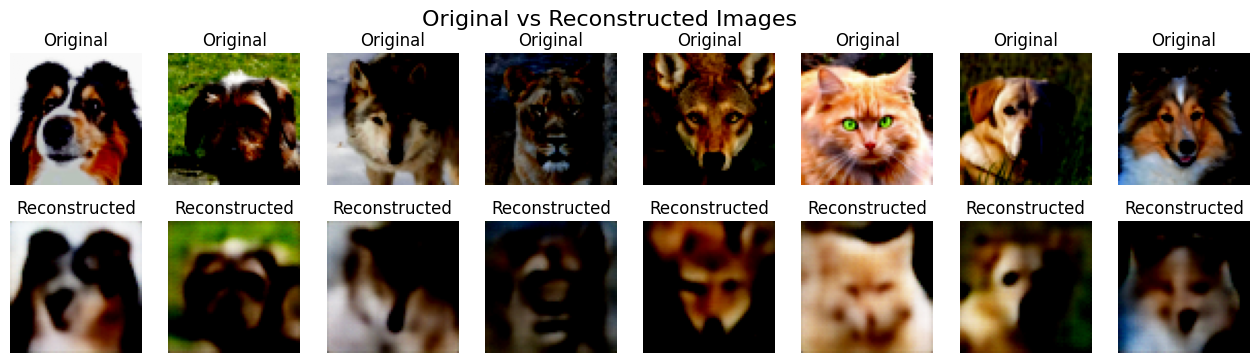

In [74]:
# Visualize reconstructions
visualize_reconstructions(model, val_dataset, device)

In [18]:
def visualize_reconstructions(model, dataloader, device, mean, std, num_images=8):
    """
    Visualizes original and reconstructed images from the VAE.
    
    Args:
        model: Trained VAE model.
        dataloader: DataLoader to sample images from.
        device: Device (CPU or CUDA) to perform inference.
        mean: Mean used for normalization during dataset preprocessing.
        std: Standard deviation used for normalization during dataset preprocessing.
        num_images: Number of images to visualize.
    """
    model.eval()

    # Move mean and std to the same device as images
    mean = mean.to(device)
    std = std.to(device)

    # Randomly sample a batch of images from the dataloader
    data_iter = iter(dataloader)
    images = next(data_iter)  # Assuming the dataloader returns images and labels
    images = images.to(device)

    # If you need only `num_images` samples
    images = images[:num_images]

    with torch.no_grad():
        recon_images, _, _ = model(images)  # Pass images through the VAE

    # Denormalize the images
    images = images * std[None, :, None, None] + mean[None, :, None, None]
    recon_images = recon_images * std[None, :, None, None] + mean[None, :, None, None]

    # Convert tensors to CPU for visualization
    images = images.cpu().numpy()
    recon_images = recon_images.cpu().numpy()

    # Plot original and reconstructed images
    plt.figure(figsize=(num_images * 2, 4))

    for i in range(num_images):
        # Original images
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        plt.axis("off")
        plt.title("Original")

        # Reconstructed images
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon_images[i].transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        plt.axis("off")
        plt.title("Reconstructed")

    plt.suptitle("Original vs Reconstructed Images", fontsize=16)
    plt.show()

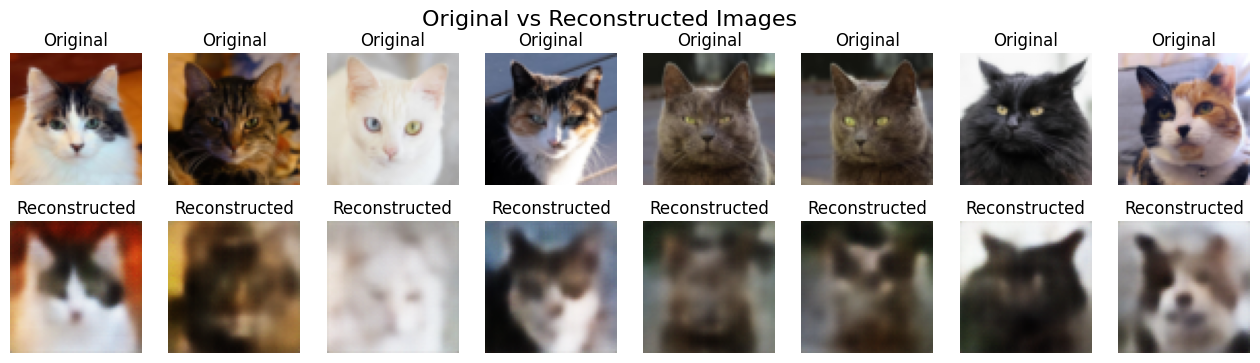

In [76]:
# Assuming images were normalized with mean and std (for example, for CIFAR-10)
mean = torch.tensor([0.5, 0.5, 0.5])  # Example mean for RGB images
std = torch.tensor([0.5, 0.5, 0.5])   # Example std for RGB images

# Visualize the images
visualize_reconstructions(model, val_loader, device, mean, std)

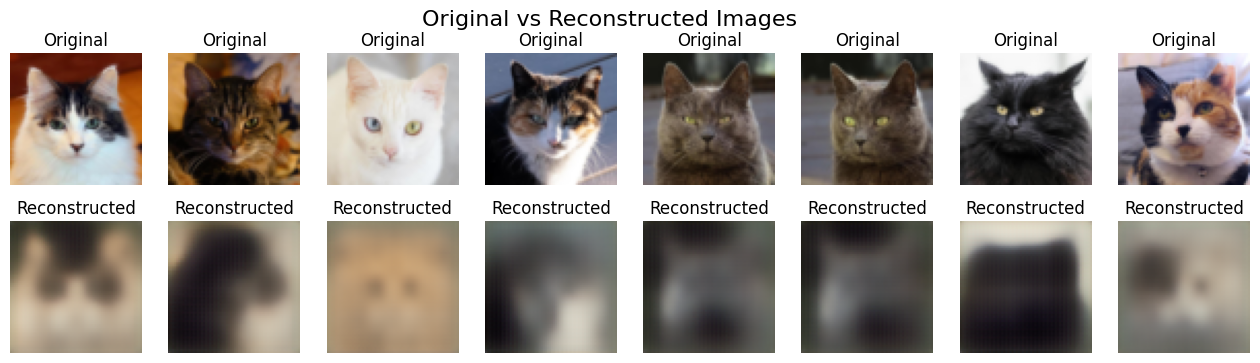

In [19]:
# Assuming images were normalized with mean and std (for example, for CIFAR-10)
mean = torch.tensor([0.5, 0.5, 0.5])  # Example mean for RGB images
std = torch.tensor([0.5, 0.5, 0.5])   # Example std for RGB images

# Visualize the images
visualize_reconstructions(model, val_loader, device, mean, std)

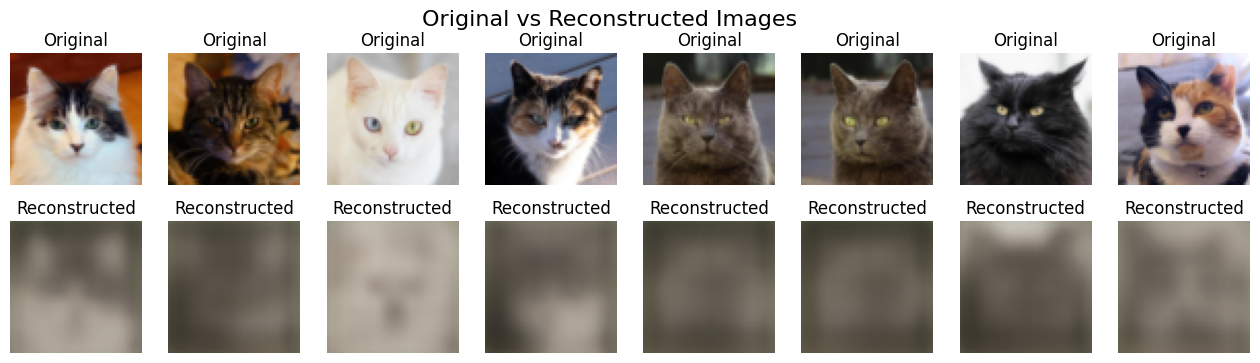

In [29]:
# Assuming images were normalized with mean and std (for example, for CIFAR-10)
mean = torch.tensor([0.5, 0.5, 0.5])  # Example mean for RGB images
std = torch.tensor([0.5, 0.5, 0.5])   # Example std for RGB images

# Visualize the images
visualize_reconstructions(model, val_loader, device, mean, std)